In [1]:
#Duygu SESVER
#504191509
#########################
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.stats import pearsonr
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx 
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#import any other  modules that you wish
#SHORTCUTS: Alt + Enter includes new cell below, CTRL + Enter executes the current cell
##########################


## Part A: Simulate random weighted and unweighted networks 

### 1. Briefly explain how Erdos-Renyi generative model works.

Each edge for all pairs of vertices is sampled independently from all the edges. It produces edges with an probability. It follows the Bernoulli Distribution for each possible edge between two nodes. There are two ways to generate the model:

ER(n, p) - this model determines the number of vertices, and each pair of nodes has p probability of an edge existing between the two.

ER(n, m) - this model chooses randomly which have the number of vertices, and the total number of edges m. For example, in the G(3, 2) model, each of the three possible graphs on three vertices and two edges are included with probability 1/3.


### 2. What are the key properties of Erdos-Renyi graphs?

A graph in G(n, p) has on average  \begin{equation} \binom{n}{2} p \end{equation} edges.


* If np < 1, then a graph in G(n, p) will almost sure with that there is no connected components of size larger than O(log(n)).
* If np = 1, then a graph in G(n, p) will almost surely have a largest component whose size is of order n2/3 .
* If np → c > 1, where c is a constant, then a graph in G(n, p) will almost surely have a unique giant component containing a positive fraction of the vertices. No other component will contain more than O(log(n)) vertices.
* Erdos-Renyi graphs are nearly the same degree distribution
* the degree distribution of an Erdos-Renyi network is binomial

Unconstrained surrogate networks were created using a variant of the Erdos-Renyi generative model. It guaranteed the network will be non-fragmented in the paper.

### 3. Briefly explain how Maslov-Sneppen algorithm works.

It is the rewiring algorithm. It annuls all network properties except for network size, connection density, and degree distribution. At each iteration, they randomly select two connections, (u1,u2) and (u3,u4). We then move (rewire) these links to introduce two new connections (u1,u4) and (u2,u3). If one or both of these new connections already exist, they abandon the iteration and randomly select another pair of connections. It measures if nodes of a given degree K1  prefer to connect to nodes of another degree K2. The idea is to compare the number of edges N(K1,K2 ) connecting any pair of nodes with degrees K1 and  K2 in the real complex network.

### 4. What are the key properties of Maslov-Sneppen graphs?

* The Maslov-Sneppen algorithm is a computationally efficient approach, although we can never be sure how many rewiring steps are required.
* The Maslov-Sneppen algorithm uses an iterative rewiring procedure

### 5. Visualize two random graphs you simulated (ER and MS).

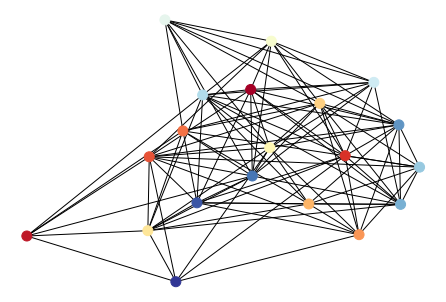

In [2]:
G= nx.erdos_renyi_graph(20,0.5) #20 node 0.5 probs

for e in G.edges():
    G[e[0]][e[1]]['weight'] = random.randint(0, 10) #To init weights
 

#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos = nx.spring_layout(G),edge_labels=labels)

nx.draw(G, node_color = range(20), cmap=plt.cm.RdYlBu, node_size = 100) 
plt.show() 

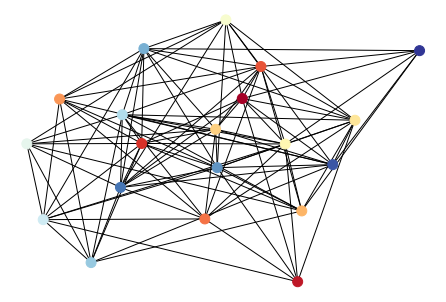

In [3]:
G= nx.algorithms.smallworld.random_reference(G) # it takes already generated graph and rewired it.
nx.draw(G, node_color = range(20), cmap=plt.cm.RdYlBu, node_size = 100) 
plt.show() 

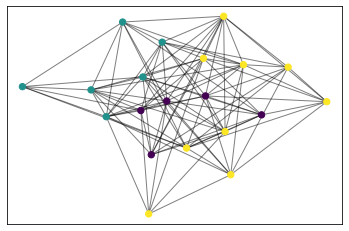

In [4]:
partition =community_louvain.best_partition(G) #it is used for community detection in run_modularity, PC
pos = nx.spring_layout(G)
import matplotlib.cm as cm
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## Part B: Analyzing Erdos-Renyi and Maslov-Sneppen graphs using centrality measures

In [5]:
#Since some of the centralities are not in networkx lib, they are implemented here.(from matlab code*)
def h_index(G):
    
    adj = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()# gives adjenceny matrix
    stlr = np.sum(adj, axis=0)
    h = np.zeros(len(stlr))
    
    for i in range(len(adj)):
        nei = stlr[adj[i,:] > 0]
        num_nei = len(nei)
        h_vals = np.zeros(num_nei)
        
        for j in range(num_nei):
            h_vals[j] = len(np.where(nei >= j))
            
        h[i] = max(min(list(range(num_nei)), list(h_vals)))
        
    return dict(zip(G.nodes(), h))

In [6]:
def Laplacian_centrality(G):
    
    A = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()    
    N = len(A);
    LAPC = np.zeros(N)
    
    if len(np.unique(A)) == 2 and np.max(A) == 1:
        deg = np.sum(A, axis=0)
        
        for i in range(N):
            nei = (A[i,:] > 0)
            LAPC[i] = deg[i]**2 + deg[i] + 2*np.sum(deg[nei]) 
            
    else:
        
        for i in range(N):
            NWC = np.sum(A[i,:]**2)
            nei = np.where(A[i,:] > 0)[0]
            NWE = 0
            for j in range(len(nei)):
                NWE = NWE + np.sum(A[i,nei[j]]*A[:,nei[j]]) - A[i,nei[j]]*A[i,nei[j]]       
            
            NWM = 0
            for j in range(len(nei)-1):
                for k in range(j+1,len(nei)):
                    NWM = NWM + A[i,nei[j]]*A[i,nei[k]]
                                 
            LAPC[i] = 2*NWE + 2*NWM + 4*NWC
                                 
    return dict(zip(G.nodes(), LAPC))



In [7]:
def leverage_centrality(G):
    adj = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()
    stlr = np.sum(adj, axis=0)
    l = np.zeros(len(adj))
    for i in range(len(adj)):
        Ni = stlr[adj[:,i] > 0]
        l[i] = np.mean((stlr[i] - Ni)/(stlr[i] + Ni))
        
    return dict(zip(G.nodes(), l))

In [8]:
def run_modularity(G):
    
    W = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()
    
    n=len(W)
    Ko=np.sum(W,axis=1)
    partition =community_louvain.best_partition(G)
    
    Gc=np.diag(list(partition.values()))
    Kc2=np.zeros(n)
    for i in range(np.max(list(partition.values()))):
            
            Kc2=Kc2+(np.sum((Gc==i), axis=0)**2)
            
    P=np.ones(n)-Kc2/(Ko**2)
    
    return dict(zip(G.nodes(), P))

In [9]:
def random_walk_centrality(G):
    
    adj = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()
    
    M = np.diag(1./np.sum(adj,axis=1))*adj
    n = len(M)

    """
    if max(np.diag(M)) == 1:
        error('The transition matrix contains an absorbing state!')  
    
    if max(np.isnan(M)) == 1:
        error('The transition matrix is not irreducible!')
    
    comp = graphComponents(M):
    if np.sum(comp, axis=0) != len(comp):
        error('The transition matrix is not irreducible!')
    """
    I = np.identity(n)    
    A = M-I    
    A[:,-1] = np.ones(n)    
    O = np.zeros(n)
    O[-1] = 1
    s = np.linalg.lstsq(A.T, O.T)[0].T
    S = np.tile(s, (n, 1))
    Z = np.linalg.inv(I-M+S)
    H = (np.tile(np.diag(Z),(n,1))-Z)/S 
    RWC = n/np.sum(H, axis=0)
    
    return dict(zip(G.nodes(), RWC))

In [10]:
def bridging_centrality(G, b):
    
    A = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()
    b=list(b.values())    
    n=len(A)
    d=np.sum(A, axis=0)
    if max(b) > 1:
        b=b/((n-1)*(n-2))
    
    c=np.zeros(len(b))
    L = (A > 0)*1
    for k in range(n):
        c[k]=(1./d[k])/np.sum(1./d[L[:,k]])
    
    bc=b*c
    
    return dict(zip(G.nodes(), bc))

In [11]:
def _communicability(c):    
    mtrx = []
    for key,value in c.items():
        mtrx.append(np.array(list(value.values())))
    mtrx = np.array(mtrx)
    return mtrx

In [12]:
def create_network(numOfNetwork, numOfNodes): # This function create weighted and unweighted networks.
    weighted_graphs = []
    unweighted_graphs = []
    for i in range(numOfNetwork):
        
        G = nx.erdos_renyi_graph(numOfNodes, 0.5) #erdos-renyi

        G2= nx.algorithms.smallworld.random_reference(G) #maslov-sneppen(unw)
        unweighted_graphs.append(G2)
        
        for e in G.edges():
            G[e[0]][e[1]]['weight'] = random.randint(1, 10) #add weights

        weighted_graphs.append(G)

    return weighted_graphs, unweighted_graphs
        
    
def calculate_centralities(graphs): #This function calculates 17 centralities for each graph
    all_centralities = []
    for G in graphs:
        centralities = []
        centralities.append(nx.degree_centrality(G))                                               #DC
        bc = nx.betweenness_centrality(G, weight = 'weight')                                       #BC
        centralities.append(bc)
        centralities.append(nx.eigenvector_centrality(G, weight = 'weight'))                       #EC
        centralities.append(nx.pagerank(G, weight = 'weight'))                                     #PR
        centralities.append(nx.closeness_centrality(G, distance="weight"))                         #CC 
        c = nx.communicability(G) 
        c_mtrx = _communicability(c)
        centralities.append(dict(zip(c.keys(), c_mtrx.diagonal())))                                #SC
        centralities.append(random_walk_centrality(G))                                             #RWCC
        centralities.append(h_index(G))                                                            #HC
        centralities.append(leverage_centrality(G))                                                #LC
        centralities.append(nx.information_centrality(G, weight = 'weight'))                       #IC
        centralities.append(nx.katz_centrality_numpy(G, weight = 'weight'))                        #KC
        centralities.append(dict(zip(c.keys(),np.sum(c_mtrx, axis=1))))                            #TCC
        centralities.append(nx.current_flow_betweenness_centrality(G,  weight = 'weight'))         #RWBC
        centralities.append(nx.communicability_betweenness_centrality(G))                          #CBC
        centralities.append(run_modularity(G))                                                     #PC
        centralities.append(Laplacian_centrality(G))                                               #LC
        centralities.append(bridging_centrality(G, bc))                                            #BC
        all_centralities.append(centralities)
    
    return all_centralities

def calculate_correlations(all_centralities): #This function calculates correlations between different centrality measures for each graph
    """
    Returns :  Up diagonal of correlation matrix and correlation matrix
    """
    corrs = []
    corr_matrix = []
    for centralities in all_centralities: #all graphs centralities
        correlations = []
        for i in centralities: #Each graphs' all centralities
            correlation = []
            for j in centralities:#Each graphs' all centralities to calculate correlations between them
                corr, _ = pearsonr(list(i.values()), list(j.values()))
                correlation.append(corr)
            correlations.append(correlation)
            
        correlations = np.array(correlations)
        
        ui=np.triu_indices(len(correlations),1)
        
        corrs.append(correlations[ui])
        corr_matrix.append(correlations)
        
    return corrs, np.array(corr_matrix)
    
def plot_distributions(corr, corrs_unwei): # PLots random 5 unweighted and weighted CMCs
     
    idx = np.random.randint(len(corr), size=5)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
    fig.text(0.09, 0.4,'Centrality Measure Correlations', ha='center', rotation='vertical')
    fig.text(0.5, 0.08,'Unweighted Networks', ha='center')
    fig.text(0.5, 0.49,'Weighted Networks', ha='center')
    
    for i in range(1,6):
        randomFloatList = [] #this will represents corr in x axis randomly? i.e DC to EC...
        
        N = corr[idx[i-1]]
        NUnwei = corrs_unwei[idx[i-1]]
            
        for j in range(0, len(corr[idx[1]])):
            x = round(random.uniform(-0.1, 0.1), 2)
            randomFloatList.append(x)
            
        ax = fig.add_axes([0,0,1,1])       
        plt.subplot(2, 5, i)
        plt.xlabel('Graph ' + str(idx[i-1]))
        bx = sns.violinplot(y=N, palette="Pastel1")
        bx.set_xlim([-0.5,0.5])
        bx.set_ylim([-1,1])
        bx.scatter(randomFloatList,N, color='k') # you can comment out the dots to see density
        
        
        plt.subplot(2, 5, i+5)
        plt.xlabel('Graph ' + str(idx[i-1]))
        bx = sns.violinplot(y=NUnwei, palette="Pastel1")
        bx.set_xlim([-0.5,0.5])
        bx.set_ylim([-1,1])
        bx.scatter(randomFloatList,NUnwei, color='k')# you can comment out the dots to see density

    plt.show()

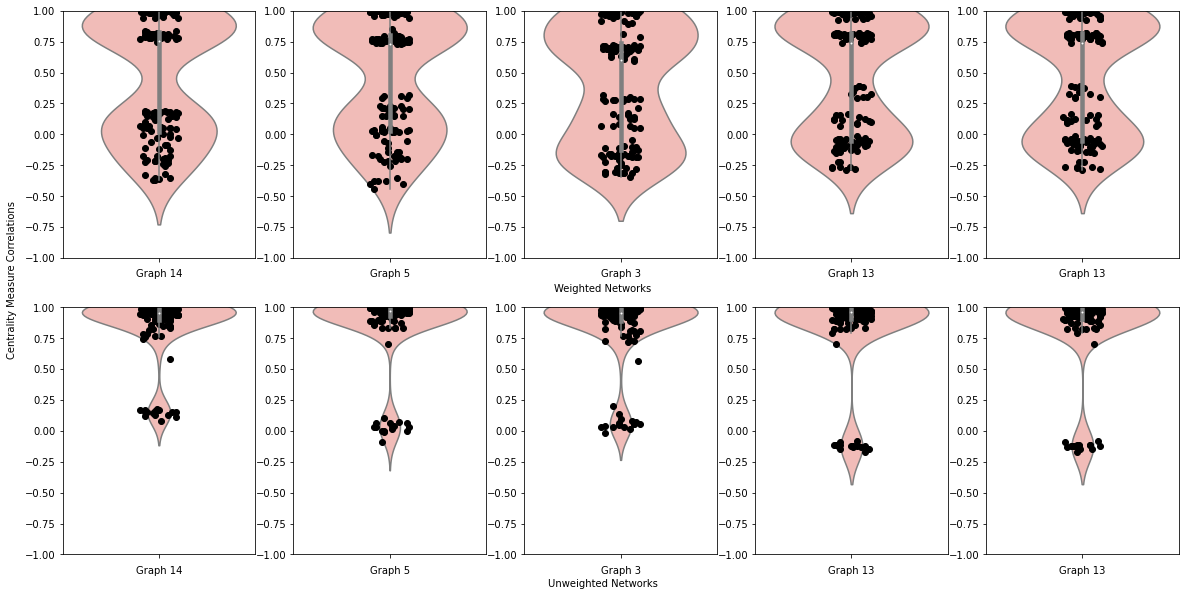

In [13]:
weighted_graphs, unweighted_graphs = create_network(20, 50) #Creates graphs
all_centralities = calculate_centralities(weighted_graphs) #calculates centrality for weighted graphs
corrs, corr_matrix = calculate_correlations(all_centralities) #calculates correlations and correlation matrix

all_centralities_unwei = calculate_centralities(unweighted_graphs)#calculates centrality for weighted graph
corrs_unwei, corr_matrix_unwei = calculate_correlations(all_centralities_unwei)#calculates correlations and correlation matrix
plot_distributions(corrs, corrs_unwei)

### What conclusions can you derive from the plots?

From this plots we can derive that even most of the networks have positive correlation between other centrality measures in unweigted netorks, also we can see a little negative correlation some of the measuresin that graphs. In weighted graphs, we can see more negative correlations but it might depends on initialization. Also there is heterogeneity in centrality measure correlation measure patterns across different networks. X-axis represents CMC types(DC to EC, DC to KC...) but indexes are assigned randomly.  

In [14]:
def plot_heatmap(corr_matrix, corr_matrix_unwei):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    
    m1 = corr_matrix.mean(axis=0) #calculate mean of all weighted graphs' corr matrix
    std1 = corr_matrix.std(axis=0) #calculate std of all weighted graphs' corr matrix
    m2 = corr_matrix_unwei.mean(axis=0) #calculate mean of all unweighted graphs' corr matrix
    std2 = corr_matrix_unwei.std(axis=0) #calculate std of all unweighted graphs' corr matrix
    list_of_plot = [m1, std1, m2, std2]
    
    list_of_labels = ['Mean Weighted', 'Std Weighted', 'Mean Unweighted', 'Std Unweighted']
    
    idx = 0
    for p in list_of_plot:
        df = pd.DataFrame(p, index = [i for i in ["DC", "BC", "EC", "PR", "CC", "SC", "RWCC", "HC", "LC", "IC", "KC", "TCC", "RWBC", "CBC", "PC", "LAPC", "BridC"]],
                  columns = [i for i in ["DC", "BC", "EC", "PR", "CC", "SC", "RWCC", "HC", "LC", "IC", "KC", "TCC", "RWBC", "CBC", "PC", "LAPC", "BridC"]])
        plt.figure(figsize = (15,1)) 
        
        sns.heatmap( df, fmt='g',ax= axes[idx])
        axes[idx].set_xlabel(list_of_labels[idx])
        idx = idx + 1

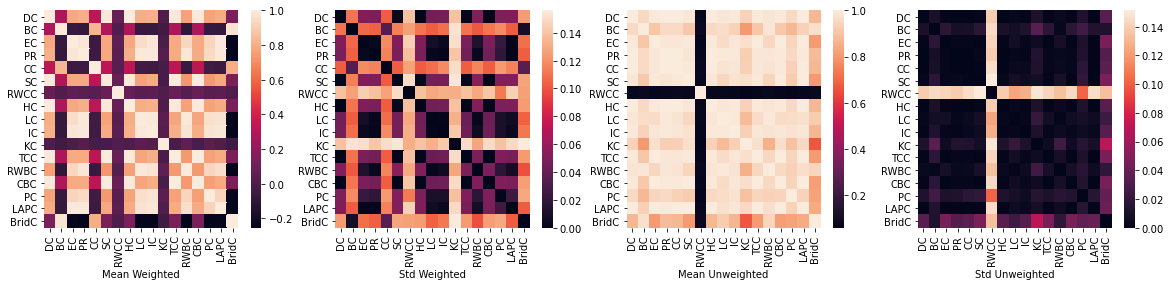

<Figure size 1080x72 with 0 Axes>

<Figure size 1080x72 with 0 Axes>

<Figure size 1080x72 with 0 Axes>

<Figure size 1080x72 with 0 Axes>

In [15]:
plot_heatmap(corr_matrix, corr_matrix_unwei)

### What conclusions can you derive from the plots?

We can see which pairs of centrality measures were consistently correlated across networks. In first and third plot, (light colors shows positive correlation across mean of different networks) we can say that average of all networks CMC are positively correlated. Second and fourth plots shows standard deviation in all networks, dark colers shows standard deviation is less across the networks. Most measures show moderate-to-high correlations across all networks. Weighted CMCs were slightly weaker than their unweighted counterparts.

In [16]:
def plot_barplot(corrs, corrs_unwei):
    randomlist = [i for i in range(0,len(corrs))]

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))
    
    plot_list = [corrs, corrs_unwei]
    fig.text(0.09, 0.4,'Centrality Measure Correlations', ha='center', rotation='vertical')
    fig.text(0.5, 0.08,'Unweighted Networks', ha='center')
    fig.text(0.5, 0.49,'Weighted Networks', ha='center')
    idx = 0
    for p in plot_list:
        ax[idx].set_xlim([-1,21])
        ax[idx].set_ylim([-1,1])
        sns.boxplot(x=randomlist,y=p, palette="Blues",ax = ax[idx])
        idx = idx + 1

    

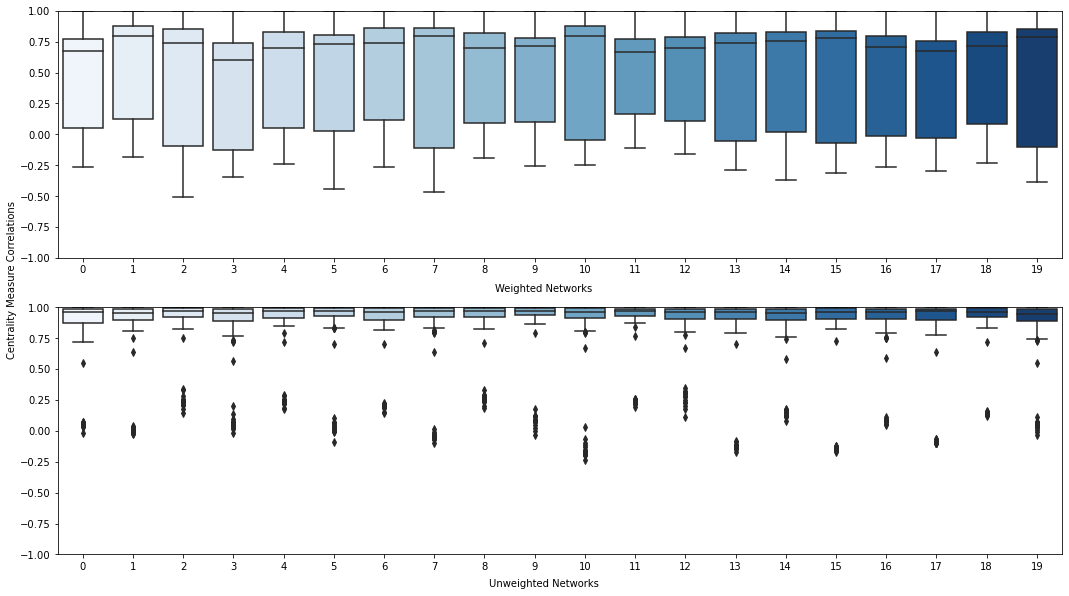

In [17]:
plot_barplot(corrs, corrs_unwei)

### What do you notice?

CMCs in weighted networks were only slightly weaker than their unweighted forms. Correlations are high generally, but some measures shows low correlations with other measures. Especially, we can see correlation differences between weighted and unweighted graphs clearly. Also, There is almost no exception in the bar plot for unweighted graphs(generally high correlation)

## Part C: Association between mean within-network Centrality Measure Correlation(CMC) and network properties

In [18]:
#Implement PART C:

def calculate_density(graphs):
    densities = []
    for G in graphs:
        densities.append(nx.density(G))
        
    return densities


def calculate_assortivity(graphs):
    assortivities = []
    for G in graphs:
        assortivities.append(nx.degree_assortativity_coefficient(G))
        
    return assortivities


In [19]:


def calculate_majorization_gap(graphs):
    mgaps = []
    for G in graphs:
        adj = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()
        d = np.sum(adj, axis=0)
        
        
        d = np.sort(d)[::-1]
        n = len(d)
        dk = np.zeros(n)
        for k in range(n):
            dk[k] = np.sum(d[:k] >= k) + np.sum(d[k+1:] >= k)
        
        
        x = dk - d
        tmg = 0.5*np.sum(x[x>0], axis=0)
        edges = np.sum(d,axis=0)/2
        tmg_norm = tmg/edges;
    
        mgaps.append(tmg_norm)
        
    return mgaps


def calculate_spectral_gap(graphs):
    sgaps = []
    for G in graphs:
        adj = nx.to_numpy_matrix(G, nodelist=list(G.nodes())).getA()
        
        adj = np.maximum(0, adj)
        V = np.linalg.eig(adj)[0]
        E = np.sort(V)[::-1]
        SGAP_norm = 1-(E[2]/E[1])
        
        sgaps.append(SGAP_norm)
        
    return sgaps


In [20]:
def plot_network_props(weighted_graphs, unweighted_graphs):
    
    
    wei_assort = calculate_assortivity(weighted_graphs)
    m_cmc_assort = np.array(corrs).mean(axis=1)

    unwei_assort = calculate_assortivity(unweighted_graphs)
    m_cmc_unwei_assort = np.array(corrs_unwei).mean(axis=1)

    wei_dens = calculate_density(weighted_graphs)
    m_cmc_density = np.array(corrs).mean(axis=1)

    unwei_dens = calculate_density(unweighted_graphs)
    m_cmc_unwei_density = np.array(corrs_unwei).mean(axis=1)
    
    wei_mgap = calculate_majorization_gap(weighted_graphs)
    m_cmc_mgap = np.array(corrs).mean(axis=1)

    unwei_mgap = calculate_majorization_gap(unweighted_graphs)
    m_cmc_unwei_mgap = np.array(corrs_unwei).mean(axis=1)

    wei_sgap = calculate_spectral_gap(weighted_graphs)
    m_cmc_sgap = np.array(corrs).mean(axis=1)

    unwei_sgap = calculate_spectral_gap(unweighted_graphs)
    m_cmc_unwei_sgap = np.array(corrs_unwei).mean(axis=1)

    
    result_list = [wei_assort, m_cmc_assort, unwei_assort, m_cmc_unwei_assort, wei_dens, m_cmc_density, unwei_dens,
                  m_cmc_unwei_density, wei_mgap, m_cmc_mgap, unwei_mgap, m_cmc_unwei_mgap, wei_sgap, m_cmc_sgap,
                  unwei_sgap, m_cmc_unwei_sgap]
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(13, 3))
    fig.text(0.09, 0.25,'Mean within network CMC', ha='center', rotation='vertical')
    co = []
    co.append(pearsonr(wei_assort + unwei_assort, list(m_cmc_assort) + list(m_cmc_unwei_assort))[0])
    co.append(pearsonr(wei_dens + unwei_dens, list(m_cmc_density) + list(m_cmc_unwei_density))[0])
    co.append(pearsonr(wei_mgap + unwei_mgap, list(m_cmc_mgap) + list(m_cmc_unwei_mgap))[0])
    co.append(pearsonr(wei_sgap + unwei_sgap, list(m_cmc_sgap) + list(m_cmc_unwei_sgap))[0])
    
    list_of_labels = ['Assotivity', 'Density', 'Majorization Gap', 'Spectral Gap']
    for i in range(4):
        ax[i].set_title("ρ: " + str(co[i]))
        ax[i].scatter(result_list[4*i], result_list[4*i+1],color='red') # weighted
        ax[i].scatter(result_list[4*i+2], result_list[4*i+3],color='green') #unweighted
        
        ax[i].set_xlabel(list_of_labels[i])
    

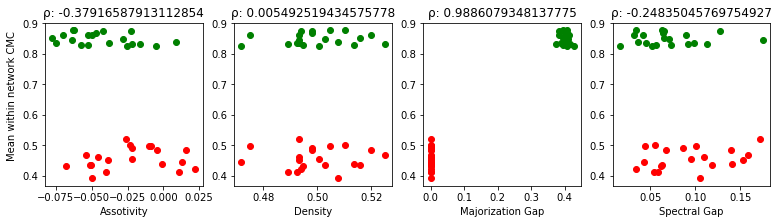

In [21]:
plot_network_props(weighted_graphs, unweighted_graphs)

### What conclusions can you derive?

In unweighted networks, higher mean within-network CMC was correlated. For the weighted and unweighted graphs correlation coefficient is almost zero except majorization gap property. In majorization gap property, weighted graps are almost eqoal to zero